# Analysis of the Experimental Results
Apply multivariate analysis of the experimental results

## Questions to investigate
For each of the clustering methods which one provides the best clustering of stations for the variants of epsilon nad maxPts. Best clustering can be defined as:
1. Most number of clusters with most number of stations (i.e. least noise)
1. Maximum quality measure with the silhouette coefficient, calinzki-harabaz score, davis-bouldin score, and dunn index

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

''' Dictionary of clustering processes to use with color pallet to make the coloring consistent across
    all types of plots '''
_dict_clust_procs = {0:"DBSCAN-auto",1:"HDBSCAN-best-eom",2:"HDBSCAN-best-leaf",3:"OPTICS-auto-xi",
                     4:"OPTICS-auto-dbscan",5:"MEANSHIFT",6:"AGGLOMERATIVE",7:"AFFINITYPROPAGATION",8:"BIRCH",
                     9:"GREEDY-random",10:"GREEDY-integer",11:"ASYNC-LPA-random",12:"LABEL-PROPAGATION",
                     13:"GIRVAN-NEWMAN",14:"KMEANS",15:"SPECTRAL-discretize-lobpcg"}
print("Dictionary of clustering process with parametric variations\n",_dict_clust_procs)

Dictionary of clustering process with parametric variations
 {0: 'DBSCAN-auto', 1: 'HDBSCAN-best-eom', 2: 'HDBSCAN-best-leaf', 3: 'OPTICS-auto-xi', 4: 'OPTICS-auto-dbscan', 5: 'MEANSHIFT', 6: 'AGGLOMERATIVE', 7: 'AFFINITYPROPAGATION', 8: 'BIRCH', 9: 'GREEDY-random', 10: 'GREEDY-integer', 11: 'ASYNC-LPA-random', 12: 'LABEL-PROPAGATION', 13: 'GIRVAN-NEWMAN', 14: 'KMEANS', 15: 'SPECTRAL-discretize-lobpcg'}


### Get station data

___Note:___ You may skip retrieving data and running the prolonged clustering process and simply work analyze the quality measures from the ```results.csv``` file stored in the ```experiments``` folder.

In [150]:
''' Get all stations  '''
import sys
sys.path.insert(1, '../lib')
import stations
import datetime

try:
    now = datetime.datetime.now()
    print ("Current run date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    print('Please wait while we retrieve GeoNet station inventory data')
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list, _ = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError

    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} active stations inside the main geographic land boundaries.')
    print(f'and {len(invalid_st_list)} active stations outside the main geographic land boundaries.')
    print('Complete')

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Current run date and time : 
2021-12-27 10:39:57
Please wait while we retrieve GeoNet station inventory data


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In the inventory of 456 total station
There are 452 active stations inside the main geographic land boundaries.
and 4 active stations outside the main geographic land boundaries.
Complete


In [151]:
import pandas as pd

try:
    ''' Define the list of station types to filter the station inventory data {"EH","HH","HN","LN"}'''
    __lst_st_type_80Hz_above = ['HN','LN']
    lst_st_80Hz_above = [[st_name,st_type, st_lat,st_lon]
                         for st_name,st_type,st_lat,st_lon in st_list
                         if st_type in __lst_st_type_80Hz_above]
    station_df = pd.DataFrame(lst_st_80Hz_above, columns=['st_name','st_type','st_lat','st_lon'])

    ''' Initialize label column as -1 indicating individual stations to be noise to begin with '''
    l_label = [-1]*station_df.shape[0]
    station_df['label'] = -1
    station_df.set_index(['st_type','label'])

    print('%d stations of type %s are ready for clustering' % (station_df.shape[0],__lst_st_type_80Hz_above))

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

284 stations of type ['HN', 'LN'] are ready for clustering


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get clustering sequence parameters

#### Set file names and parameters

In [15]:
''' Set relevant parameters used throughout all cells

    @_force_regularity = {'Absolute','Average','minPoints','None'}
       Absolute - is a brute force to check all constraints
       Average - checks if average degree of nodes in cluster >= minPts-1
       minPoints - simply checks for minimum samples and doesn't enforce regularity
       None - doesn't do anything but simply creates a list of simple graphs corresponding to each cluster
'''
_force_regularity = "Absolute"
print('Regularity enforcement: %s' % (_force_regularity))

''' Set file names to read clustering sequence and write results to;
    including writing clusters that cannot be validated for quality'''
''' complete run '''
_s_seq_input_file = "./cluster_runs.csv"
_s_results_file = "./results_"+_force_regularity+".csv"
_err_file_name = "./err_clustering_"+_force_regularity+".txt"

''' Naive-greed run - because it takes a long time '''
#_s_seq_input_file = "./cluster_runs_naivegreedy.csv"
#_s_results_file = "./results_naivegreedy_"+_force_regularity+".csv"
#_err_file_name = "./err_clustering_naivegreedy_"+_force_regularity+".txt"

''' Spectral determine K run - because it takes a long time '''
#_s_seq_input_file = "./cluster_runs_spectral_evalOptimRun.csv"
#_s_results_file = "./results_spectral_evalOptimRun_"+_force_regularity+".csv"
#_err_file_name = "./err_clustering_spectral_evalOptimRun_"+_force_regularity+".txt"

''' test run - for checking code'''
#_s_seq_input_file = "./test_cluster_runs.csv"
#_s_results_file = "./test_results_"+_force_regularity+".csv"
#_err_file_name = "./test_err_clustering_"+_force_regularity+".txt"

print('Data files to be used:')
print('...input  :%s ' % _s_seq_input_file)
print('...results:%s ' % _s_results_file)
print('...errors :%s ' % _err_file_name)
print("\nReady to run clustering")

Regularity enforcement: Absolute
Data files to be used:
...input  :./cluster_runs.csv 
...results:./results_Absolute.csv 
...errors :./err_clustering_Absolute.txt 

Ready to run clustering


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Run clustering strategies
___Skip this if already run and only analyzing the results___

In [249]:
''' Get clustering experiment sequence parameters from the spreadsheet '''
import pandas as pd
import sys; sys.path.insert(1, '../lib')
import cluster_quality as cq
import graph_clustering as gc
import cloud_clustering as cc
import importlib

if debug:
    import importlib
    cq = importlib.reload(cq)
    cc = importlib.reload(cc)
    gc = importlib.reload(gc)

import sys
import time
#import traceback

''' declare quality class, results dataframe, and number of erros '''
clust_quality = cq.cluster_quality_metric()
results_df_ = pd.DataFrame([])     # dataframe to store the results
#d_n_errs = 0

''' Load data from CSV '''
_run_seq_df = pd.read_csv(_s_seq_input_file)
_err_file=None
#d _err_file = open(_err_file_name,'w')     # start file to log all errors
_s_seq_name = None
_s_meth_name = None
_s_algo_name = None
_n_errs = 0

print('File %s contains clustering strategies for processes\n%s'
      % (_s_seq_input_file, sorted(_run_seq_df['name'].unique())))
print('Start clustering and acquire quality parameters for %d strategies' % _run_seq_df.shape[0])
print('This may take a while ...\n')
_run_seq_df.sort_values(by=['technique','name'])
for _n_exp_seq in range(_run_seq_df.shape[0]):
    s_clust_cls_, s_clust_name_, dict_params_ = clust_quality.get_seq_params(_run_seq_df, _n_exp_seq)
    ''' print current strategy name for monitoring progress '''
    if (_s_seq_name != s_clust_name_):
        _s_seq_name = s_clust_name_
        print('...Starting strategy %d with %s clustering.'
              % (_n_exp_seq, s_clust_name_))
    ''' Get clusters for given strategy with parameter dictionary '''
    st_clust_df_ = pd.DataFrame([])     # dataframe for the stations and cluster labels
    st_clust_df_ = clust_quality.get_clusters(dict_params_,
                                              station_df,
                                              s_clust_cls_,
                                              s_clust_name_)

    ''' apply r-regularity to further validate the culsters '''
    if _force_regularity in ['Absolute','Average','minPoints','None']:
        _dict_reg_param = {"force_regularity":_force_regularity}
        st_clust_df_,lst_G_simple = clust_quality.get_r_regular_clusters(_dict_reg_param,st_clust_df_)
    
    _n_clusters = len([x for x in st_clust_df_['label'].unique() if x > -1])

    if _n_clusters > 1:
        clust_quality.set_quality_frame(clustering_name=s_clust_name_, **dict_params_)
        results_df_=results_df_.append(clust_quality.get_quality_metrics(st_clust_df_))

    else:
#d        if isinstance(_err_file,type(None)):
        if _n_errs <= 0:
            _err_file = open(_err_file_name,'w')     # start file to log all errors
        _n_errs += 1
        _s_err = s_clust_name_+': '+''.join(str(dict_params_.keys()))
        _s_err += '\n'+''.join(str(dict_params_.values()))+'\n'
        _err_file.write(_s_err)
#d        print('No results were added for %s' % _s_err)

if results_df_.shape[0] > 0:
    l_seq = list(range(0,(results_df_.shape[0])))
    results_df_.insert(0, 'Sequence', l_seq)
    results_df_.set_index('Sequence')
    results_df_.to_csv(_s_results_file, index=False)

if _n_errs > 0:
    _err_file.close()
    
print('\nOf %d sequences the quality metric results for %d sequences are stored in %s' 
      % (_n_exp_seq+1,_n_exp_seq+1-_n_errs,_s_results_file))
if not isinstance(_err_file,type(None)):
    print('%d error(s) for cluster strategy logged in %s' % (_n_errs,_err_file_name))


File ./cluster_runs_naivegreedy.csv contains clustering strategies for processes
['NAIVE-GREEDY']
Start clustering and acquire quality parameters for 20 strategies
This may take a while ...

...Starting strategy 0 with NAIVE-GREEDY clustering.


KeyboardInterrupt: 

## Load, Prepare and Enrich Quality Metrics

In [16]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#_s_seq_input_file = "./results.csv"
#_s_seq_input_file = "./results_kmeans.csv"
#_results_df=pd.read_csv(_s_seq_input_file)
_results_df=pd.read_csv(_s_results_file)
#_results_df.head()

lst_drop_cols = ['Sequence', 'Station Types', 'Station Quantity', 'Metric']
_results_df = _results_df.drop(lst_drop_cols,axis=1)

lst_norm_cols = list(["Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score",
                      "Dunn Index","Modularity","Conductance Average","Coverage Score","Performance Score"])
_results_df[lst_norm_cols] = _results_df[lst_norm_cols].apply(pd.to_numeric)
''' rename attributes '''
_results_df=_results_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_results_df.loc[_results_df.Name == "LPC", "Name"] = "LABEL PROPAGATION"
''' append algorithm and method to name '''
_results_df['Cluster Sequence'] = (_results_df['Name']+' '+_results_df['Algorithm']+
                                   ' '+_results_df['Method']+' '+_results_df['Seed'])
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("None","")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("   ","-")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace(" ","-")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.rstrip("-")
_results_df.info()
#print(_results_df['Cluster Sequence'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   maxDist                  253 non-null    float64
 1   minPts                   253 non-null    int64  
 2   Name                     253 non-null    object 
 3   Algorithm                253 non-null    object 
 4   Method                   253 non-null    object 
 5   Seed                     253 non-null    object 
 6   Generated Cluster Count  253 non-null    int64  
 7   Valid Cluster Count      253 non-null    int64  
 8   Clustered Station Count  253 non-null    int64  
 9   Unclsutered Noise Count  253 non-null    int64  
 10  Average Node Degree      253 non-null    float64
 11  Silhouette Coefficient   253 non-null    float64
 12  Calinski Harabaz score   253 non-null    float64
 13  Davies Bouldin score     253 non-null    float64
 14  Dunn Index               2

### Normalize quality measures

In [28]:
import numpy as np
from scipy.stats import shapiro, kstest, normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

_norm_df = _results_df.copy()
_shapiro_df = pd.DataFrame()
#lst_norm_cols = list(['Silhouette Coefficient',
#                      'Calinski Harabaz score',
#                      'Davies Bouldin score',
#                      'Dunn Index'])
print("Kolmogorov-Smirnov test")
for col in lst_norm_cols:
    scaled = scaler.fit_transform(np.array(_norm_df[col]).reshape(-1,1))
    _norm_df[col] = pd.DataFrame(scaled)
    stat, p = normaltest(scaled)
#    stat, p = kstest(scaled,'norm')
    print("%s\tstat: %0.4f\tp: %0.4f" %(col,stat,p))
_norm_df = _norm_df.dropna()
print('Normalization complete!')

Kolmogorov-Smirnov test
Silhouette Coefficient	stat: 23.9350	p: 0.0000
Calinski Harabaz score	stat: 272.0093	p: 0.0000
Davies Bouldin score	stat: 131.1875	p: 0.0000
Dunn Index	stat: 73.6918	p: 0.0000
Modularity	stat: 1326.5301	p: 0.0000
Conductance Average	stat: 2016.2207	p: 0.0000
Coverage Score	stat: 1416.8851	p: 0.0000
Performance Score	stat: 176.7827	p: 0.0000
Normalization complete!


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
''' Check for normality'''
from scipy.stats import shapiro


### Correlation matrix
We [plot the correlation matrix](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e) to determine if there is a single cluster quality measure we could use to analyze the clusters for each combination of clustering method, epsilon, and minPts.
* Calinski Harabaz score is positively correlated with Silhouette coefficient and the Dunn Index but negatively correlated with Davies Bouldin score; therefore, we can eliminate the Calinski Harabaz score
* However, the Silhouette coefficient, Davies Bouldin score and the Dunn Index are negatively correlated with each other
* The Silhouette coefficient and the Davies Bouldin score are closer to 0 implying we may select on of them as the quality measure.
* The **Davies Bouldin score** is furthest away from the Dunn Index and the Calinski Harabaz score, which implies it would it be the preffered choice to select as the single cluster qulity indicator.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



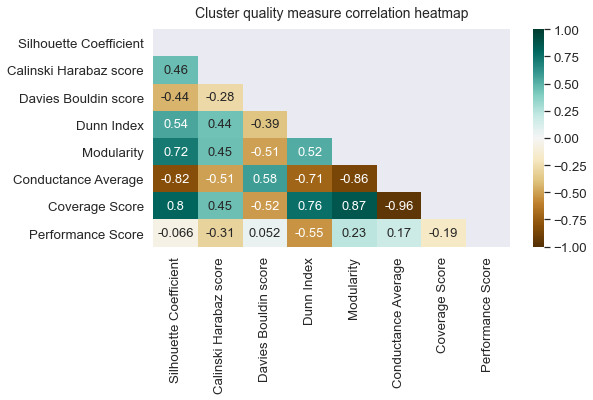

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

_corr_plt_df = _norm_df[lst_norm_cols]
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(_corr_plt_df.corr(), dtype=np.bool))

sns.set(font_scale=1.2)
heatmap = sns.heatmap(_corr_plt_df.corr(), mask=mask,
                      vmin=-1,vmax=1,annot=True,annot_kws={"size": 13},cmap='BrBG')
heatmap.set_title('Cluster quality measure correlation heatmap',fontdict={'fontsize':14}, pad=12)
plt.savefig("../images/outputs/clus_qual_corr_heatmap_"+str(_force_regularity)+".png", bbox_inches="tight")
plt.show()

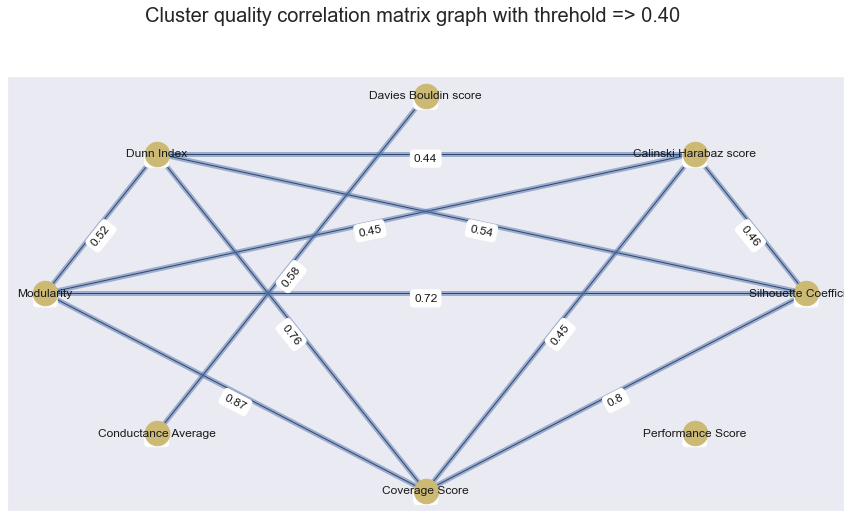

In [59]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

''' set the correlation threshold in the iterval of [-1.0,1.0] it relates to the 
    edge-weights and those edges to remove from the correlation matrix graph '''
_f_corr_thresh = 0.4
''' True: removes all edges => _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)
    False: removes all edges <= _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)'''
_remove_gt = False

''' Construct the correlation matrix graph '''
df_corr = _corr_plt_df.corr().round(2)
G = nx.from_pandas_adjacency(df_corr)
edge_weights = nx.get_edge_attributes(G,'weight')
if _remove_gt:
    G.remove_edges_from((e for e, w in edge_weights.items() if w > _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
else:
    G.remove_edges_from((e for e, w in edge_weights.items() if w < _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
G.name = "Correlation Matrix Graph"

''' Plot the graph with edges representing the correlation '''
plt.figure(figsize=(15,8))
node_pos = pos=nx.circular_layout(G)
#print(node_pos)
nx.draw_networkx(G, node_pos,node_size=600, node_color="y", node_shape='o')
nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b")
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels=edge_labels, label_pos=0.5,
                             font_size=12, font_family="Arial",
                             horizontalalignment='center', verticalalignment='top')
#nx.draw(G)
plt.suptitle(s_title,y=1.0, size=20)
plt.grid(False)
plt.savefig("../images/outputs/clus_qual_corr_g_"+str(_force_regularity)+".png", bbox_inches="tight")
plt.show()

In [18]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

factors = _norm_df[lst_norm_cols]

''' Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all
    using the observed correlation matrix against the identity matrix'''
chi_square_value,p_value=calculate_bartlett_sphericity(_norm_df[lst_norm_cols])
print("Bartlett sphericity test chi square value: %0.4f and p value: %0.4f" % (chi_square_value, p_value))
''' Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis '''
kmo_all,kmo_model=calculate_kmo(_norm_df[lst_norm_cols])
print("Kaiser-Meyer-Olkin model: %0.4f" % (kmo_model))
fa = FactorAnalyzer()
fa.set_params(n_factors=2, rotation="varimax")
fa.fit(_norm_df[lst_norm_cols])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print("\n",pd.DataFrame(ev,columns=["Eigen values"]))
print("\nLoading :\n", pd.DataFrame(fa.loadings_,index=lst_norm_cols,columns=["Factor 0","Factor 1"]))
#dprint("\nFactor variance:\n",fa.get_factor_variance())
print("\nFactor variance:\n",pd.DataFrame(fa.get_factor_variance(),
                                          index=["Variance","Propotional variance","Cummalative variance"],
                                          columns=["Factor 0","Factor 1"]))
print("\n",pd.DataFrame(fa.get_communalities(),index=_norm_df[lst_norm_cols].columns,columns=['Communalities']))

Bartlett sphericity test chi square value: 2296.1249 and p value: 0.0000
Kaiser-Meyer-Olkin model: 0.6736

    Eigen values
0      4.753367
1      1.400340
2      0.687352
3      0.620206
4      0.322449
5      0.157344
6      0.042606
7      0.016337

Loading :
                         Factor 0  Factor 1
Silhouette Coefficient  0.808194 -0.096943
Calinski Harabaz score  0.476906 -0.284974
Davies Bouldin score   -0.551207  0.066843
Dunn Index              0.641492 -0.551742
Modularity              0.948381  0.188598
Conductance Average    -0.965932  0.193728
Coverage Score          0.950066 -0.215882
Performance Score       0.026426  1.005599

Factor variance:
                       Factor 0  Factor 1
Variance              4.331733  1.530430
Propotional variance  0.541467  0.191304
Cummalative variance  0.541467  0.732770

                         Communalities
Silhouette Coefficient       0.662576
Calinski Harabaz score       0.308650
Davies Bouldin score         0.308297
Dunn Index  

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:342: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  error = sp.sum(residual)


### Plot quality measures
___TODO___ Change the color palette using a [different method](https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



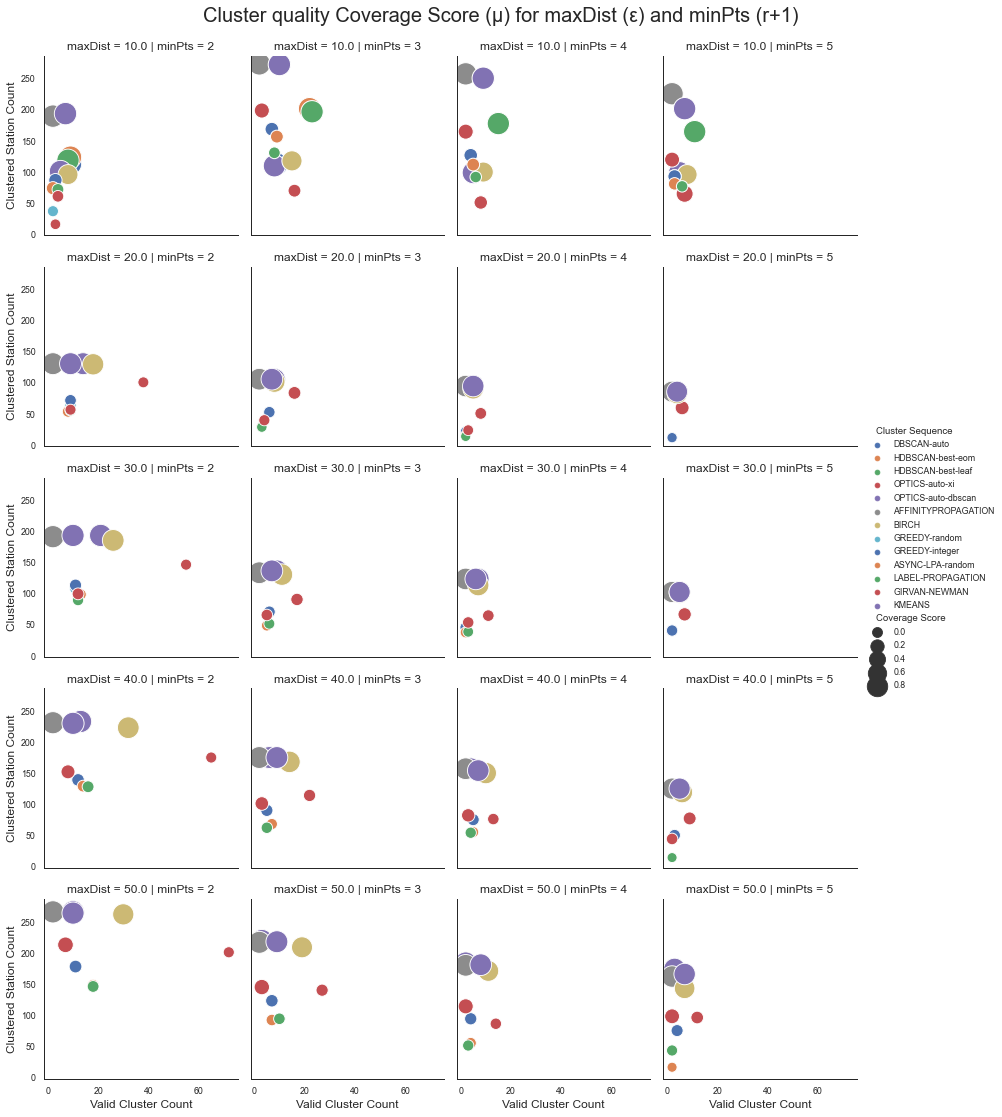

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib
''' @parameter
    use any of the quality measures to view a plot of the cluster sizes and number of stations clustered
    _s_size = {"Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score","Dunn Index",
            "Modularity","Conductance Average","Coverage Score","Performance Score"])
'''
_s_size = "Coverage Score"

''' Copy the dataframe of normalized quality measures '''
_plot_df = _norm_df.copy()
''' Plot 1.0 - Davies-Bouldin because small value means good clustering; be easier to visualize '''
_plot_df['Davies Bouldin score'] = 1-_plot_df['Davies Bouldin score']
#_plot_df['Dunn Index'] = 1-_plot_df['Dunn Index']

#_plot_df=_plot_df.rename(columns={"Maximum Distance": "maxDistance", "Minimum Points": "minPts"})
#plot_qlty_msr_df=[cloud_norm_df['Method','Cluster Count','Clustered Station Count',
#                          'Minimum Points','Distance','Davies Bouldin score']]
#plt.figure(figsize=(5,5))
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)

#_palette = sns.color_palette("deep",
#                            len(_plot_df["Cluster Sequence"].unique()))

#dprint(len(_plot_df["Cluster Sequence"].unique()))
#d_palette = sns.color_palette("deep",10)

''' Match the colors to the clustering process for plot color consistency '''
_lst_tmp_palette = sns.color_palette("deep", len(_dict_clust_procs))
_palette = []
_lst_procs = [v for k, v in _dict_clust_procs.items()]
for proc_idx, proc_name in enumerate(_lst_procs):
    if proc_name in _plot_df["Cluster Sequence"].unique():
        _palette.append(_lst_tmp_palette[proc_idx])

g=sns.relplot(
    data=_plot_df,
    row='maxDist', col='minPts',
    x="Valid Cluster Count", y="Clustered Station Count",
    hue="Cluster Sequence", size=_s_size,
    palette=_palette, 
    sizes=(100, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

_s_title = "Cluster quality "+_s_size+" (\u03BC) for maxDist (\u03B5) and minPts (r+1)"
plt.suptitle(_s_title,y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot_"+str(_force_regularity)+"_"+_s_size+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
#plt.ion()
plt.show()

## Pivot-table visualization

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plo

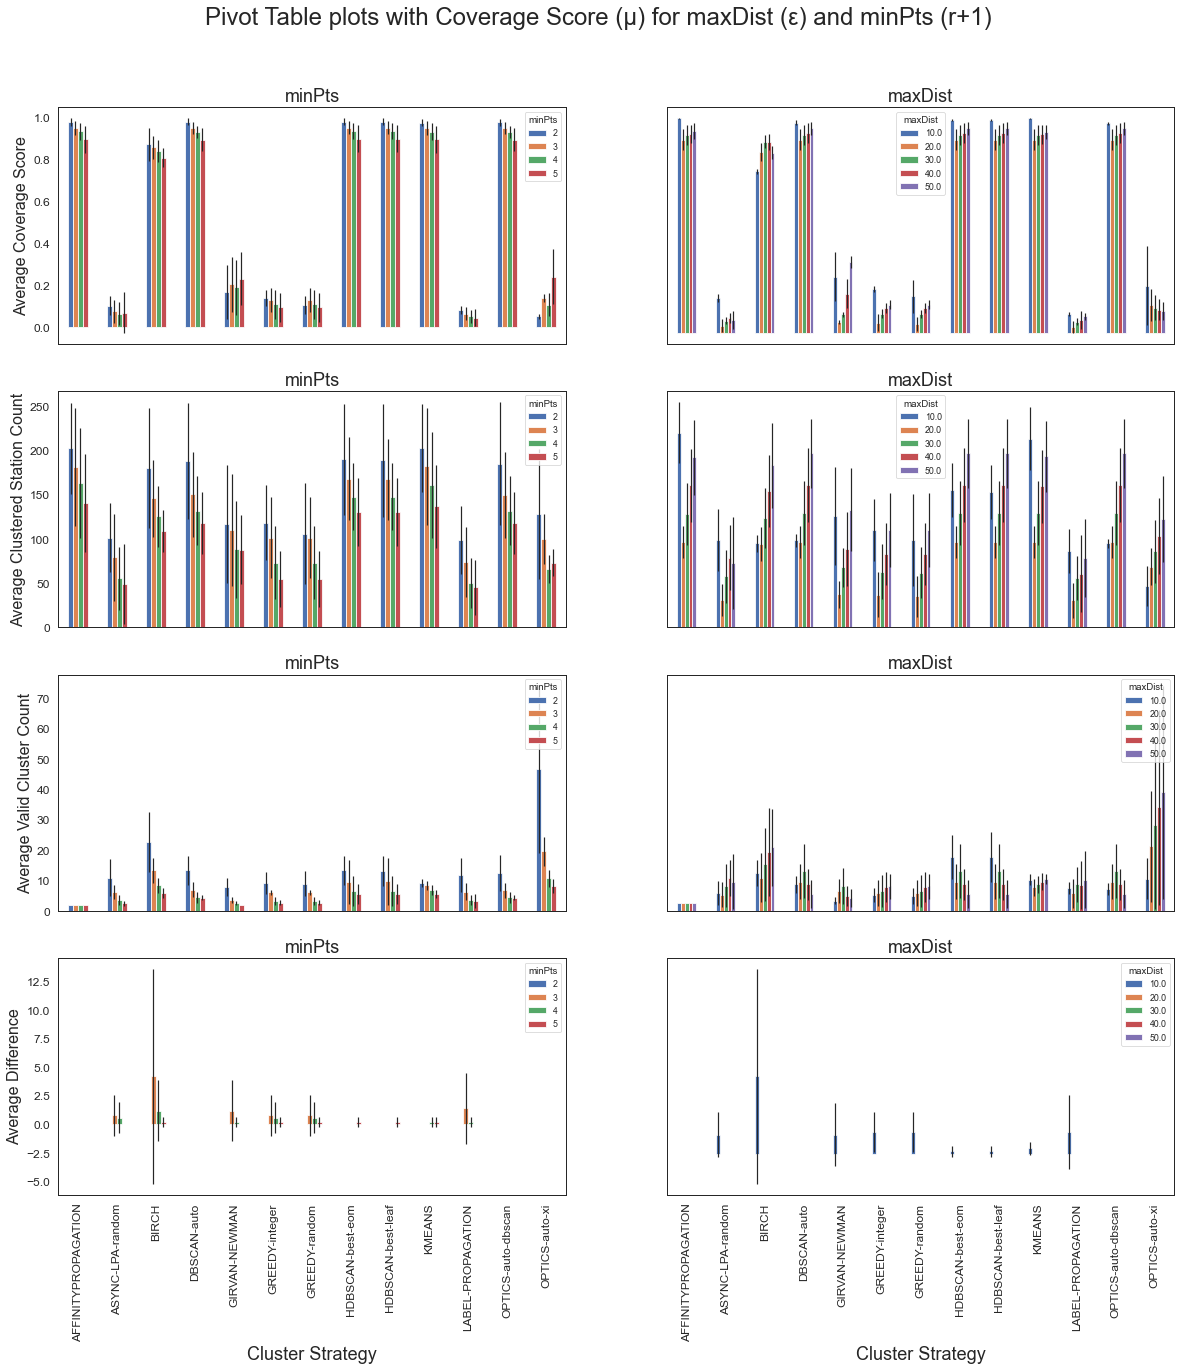

In [68]:
import matplotlib.pyplot as plt
import numpy as np

#_s_qual_mesr = "Silhouette Coefficient"
_s_qual_mesr = _s_size

cols = ["maxDist","minPts","Cluster Sequence", _s_qual_mesr,
        "Generated Cluster Count","Valid Cluster Count","Clustered Station Count"]
_pivot_df = _norm_df[cols].copy()
_pivot_df['Difference'] = (_pivot_df['Generated Cluster Count']
                           - _pivot_df['Valid Cluster Count']).astype(float)

#_pivot_df = _pivot_df[_pivot_df['Difference'] > 0]
_pivot_df=_pivot_df.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
_l_pivtab_cols = ["minPts","maxDist"]
_l_pivtab_vals = [_s_qual_mesr,"Clustered Station Count","Valid Cluster Count","Difference"]

fig, axes = plt.subplots(nrows=len(_l_pivtab_vals),
                         ncols=len(_l_pivtab_cols),
                         figsize=(20,20),
                         sharex=True,
                         #sharey=False
                        )
#plt.rcParams['figure.figsize']=(15,20)
_l_plots = []
for row_num, row_val in enumerate(_l_pivtab_vals):
    for col_num, col_val in enumerate(_l_pivtab_cols):
        _plot_df = _pivot_df.pivot_table(index=["Cluster Sequence"],
                                               #columns=["minPts","maxDist"],
                                               columns=col_val,
                                               values=row_val,
                                               aggfunc=[np.mean, np.std])
        _l_plots.append(_plot_df)
        
        _plot_df.plot(kind="bar",
                      y="mean",
                      yerr="std",
                      ax=axes[row_num,col_num],
                      #figsize=(10,10),
                      fontsize=12,
                      sharey=True)
        
#        plt.errorbar(x=_plot_df.index, y=_plot_df["mean"], _plot_df["std"], linestyle='None', marker='^')
        axes[row_num,col_num].set_title(col_val,fontdict={'fontsize':18})
        axes[row_num,col_num].set_ylabel("Average "+row_val,fontdict={'fontsize':16})
        axes[row_num,col_num].set_xlabel("Cluster Strategy",fontdict={'fontsize':18})

        _s_title = "Pivot Table plots with "+_s_size+" (\u03BC) for maxDist (\u03B5) and minPts (r+1)"
        plt.suptitle(_s_title,y=0.95, size=24)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/pivot_table_plot_"+
                        str(_force_regularity)+"_"+_s_qual_mesr+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()
#_pivot_df
#

In [69]:
print(_l_plots[0],'\n', _l_plots[1])

                         mean                                     std  \
minPts                      2         3         4         5         2   
Cluster Sequence                                                        
AFFINITYPROPAGATION  0.976298  0.948871  0.932030  0.893853  0.018125   
ASYNC-LPA-random     0.103716  0.075664  0.065559  0.070225  0.046055   
BIRCH                0.870513  0.856671  0.837549  0.806706  0.076868   
DBSCAN-auto          0.977822  0.949083  0.927714  0.893391  0.017278   
GIRVAN-NEWMAN        0.168190  0.203958  0.189482  0.231615  0.129264   
GREEDY-integer       0.138510  0.128882  0.108655  0.095282  0.038412   
GREEDY-random        0.105869  0.128882  0.108655  0.095282  0.043575   
HDBSCAN-best-eom     0.977301  0.950648  0.932671  0.898087  0.016920   
HDBSCAN-best-leaf    0.977301  0.950648  0.932671  0.898087  0.016920   
KMEANS               0.974223  0.947905  0.930145  0.893785  0.017667   
LABEL-PROPAGATION    0.084419  0.064832  0.052193  

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Difference between Generated and Valid clusters

In [70]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import ks_2samp
#import seaborn as sns
#import matplotlib.pyplot as plt
#%matplotlib inline

cols = ['maxDist','minPts','Cluster Sequence','Generated Cluster Count','Valid Cluster Count']
_df_clust_diff = _results_df[cols].copy()
_df_clust_diff['Difference'] = (_df_clust_diff['Generated Cluster Count'] 
                                - _df_clust_diff['Valid Cluster Count']).astype(float)
''' consider only records with difference != 0 '''
_diff_df = _df_clust_diff[_df_clust_diff['Difference'] > 0]
''' apply two sample KS-test to all sequences '''
_plot_df=pd.DataFrame([], columns=['Sequence','maxDiff','1-Pvalue'])
for each_seq in _diff_df['Cluster Sequence'].unique():
    _df_temp = _diff_df[_diff_df['Cluster Sequence'] ==each_seq]
    stat, pval = ks_2samp(_df_temp['Generated Cluster Count'],_df_temp['Valid Cluster Count'])
    _plot_df=_plot_df.append({'Sequence':each_seq,'maxDiff':stat, '1-Pvalue':1-pval}, ignore_index=True)

categories = _plot_df['Sequence'].to_list()
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=_plot_df['1-Pvalue'],
      theta=categories,
      fill='toself',
      name='1-Pvalue'
))
fig.add_trace(go.Scatterpolar(
      r=_plot_df['maxDiff'],
      theta=categories,
      fill='toself',
      name='maxDiff'
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True,range=[0, 1])),
    title_font_color="red",
    title={'text': "KS Test of Sequences with Differences between Generated and Valid Clusters",
           'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01)
)
''' Need to install kaleido to write image to file'''
#_s_plot_save_file = str("../images/outputs/radar_plot_ks_test.png").replace(" ","_")
#fig.write_image(_s_plot_save_file)
fig.show()

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



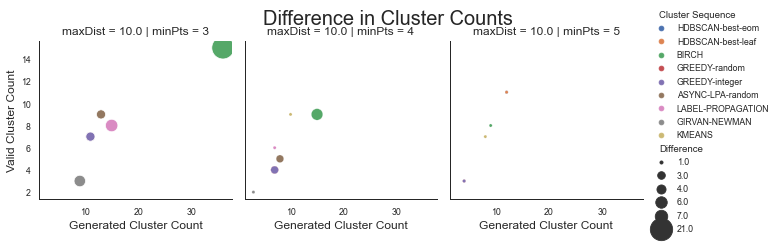

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cols = ['maxDist','minPts','Cluster Sequence',
        'Generated Cluster Count','Valid Cluster Count']
_df_clust_diff = _results_df[cols].copy()
_df_clust_diff['Difference'] = (_df_clust_diff['Generated Cluster Count'] 
                                - _df_clust_diff['Valid Cluster Count']).astype(float)
_df_clust_diff = _df_clust_diff[_df_clust_diff['Difference'] > 0]
_df_clust_diff=_df_clust_diff.rename(columns={"Maximum Distance": "maxDist", "Minimum Points": "minPts"})
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)
#g = sns.FacetGrid(data=_df_clust_diff, col="minPts", row="maxDistance")
#g.map(sns.histplot, x=_df_clust_diff["Difference"])

g=sns.relplot(
    data=_df_clust_diff,
    row='maxDist', col='minPts',
    x="Generated Cluster Count", y="Valid Cluster Count",
    hue="Cluster Sequence", size="Difference",
    palette='deep', sizes=(10, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

#for i,ax in enumerate(g.axes):
#    ax[i,0].axhline(200, ls='--', linewidth=3, color='red')

plt.suptitle("Difference in Cluster Counts",y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot_clus_diff_"+str(_force_regularity)+".png")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
plt.show()

## Redundant Code

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


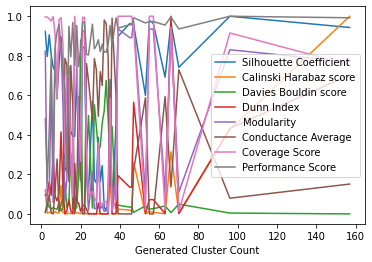

In [5]:
''' DEPRECATED doesn\'t really do much '''
import matplotlib.pyplot as plt

group_df = _norm_df.groupby("Generated Cluster Count")[["Silhouette Coefficient",
                                                        "Calinski Harabaz score",
                                                        "Davies Bouldin score",
                                                        "Dunn Index",
                                                        "Modularity",
                                                        "Conductance Average",
                                                        "Coverage Score",
                                                        "Performance Score"]].mean()
#group_df = _norm_df[["Generated Cluster Count","Silhouette Coefficient"]]

#print(group_df.head)
#plt.plot(group_df, '-o')
group_df.plot()
plt.show()

In [ ]:
''' DEPRECATED using factor analysis '''

from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
_norm_df = _results_df.copy()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(_norm_df[lst_norm_cols])
principal_df = pd.DataFrame(data = principalComponents
                            , columns = ['PC1', 'PC2'])
print(pca.explained_variance_ratio_)
#for col in principalDf['PC1', 'PC2']:
_norm_df["Principal Component"] = pd.DataFrame(scaler.fit_transform
                                               (np.array(principal_df["PC1"]).reshape(-1,1))
                                              )
#_norm_df["Principal Component"] = np.array(principal_df["PC1"])
_norm_df = _norm_df.dropna()
#print('Normalization complete!')
#_norm_df["Principal Component"] = principalDf["PC1"]

print('PCA and Normalization complete!')

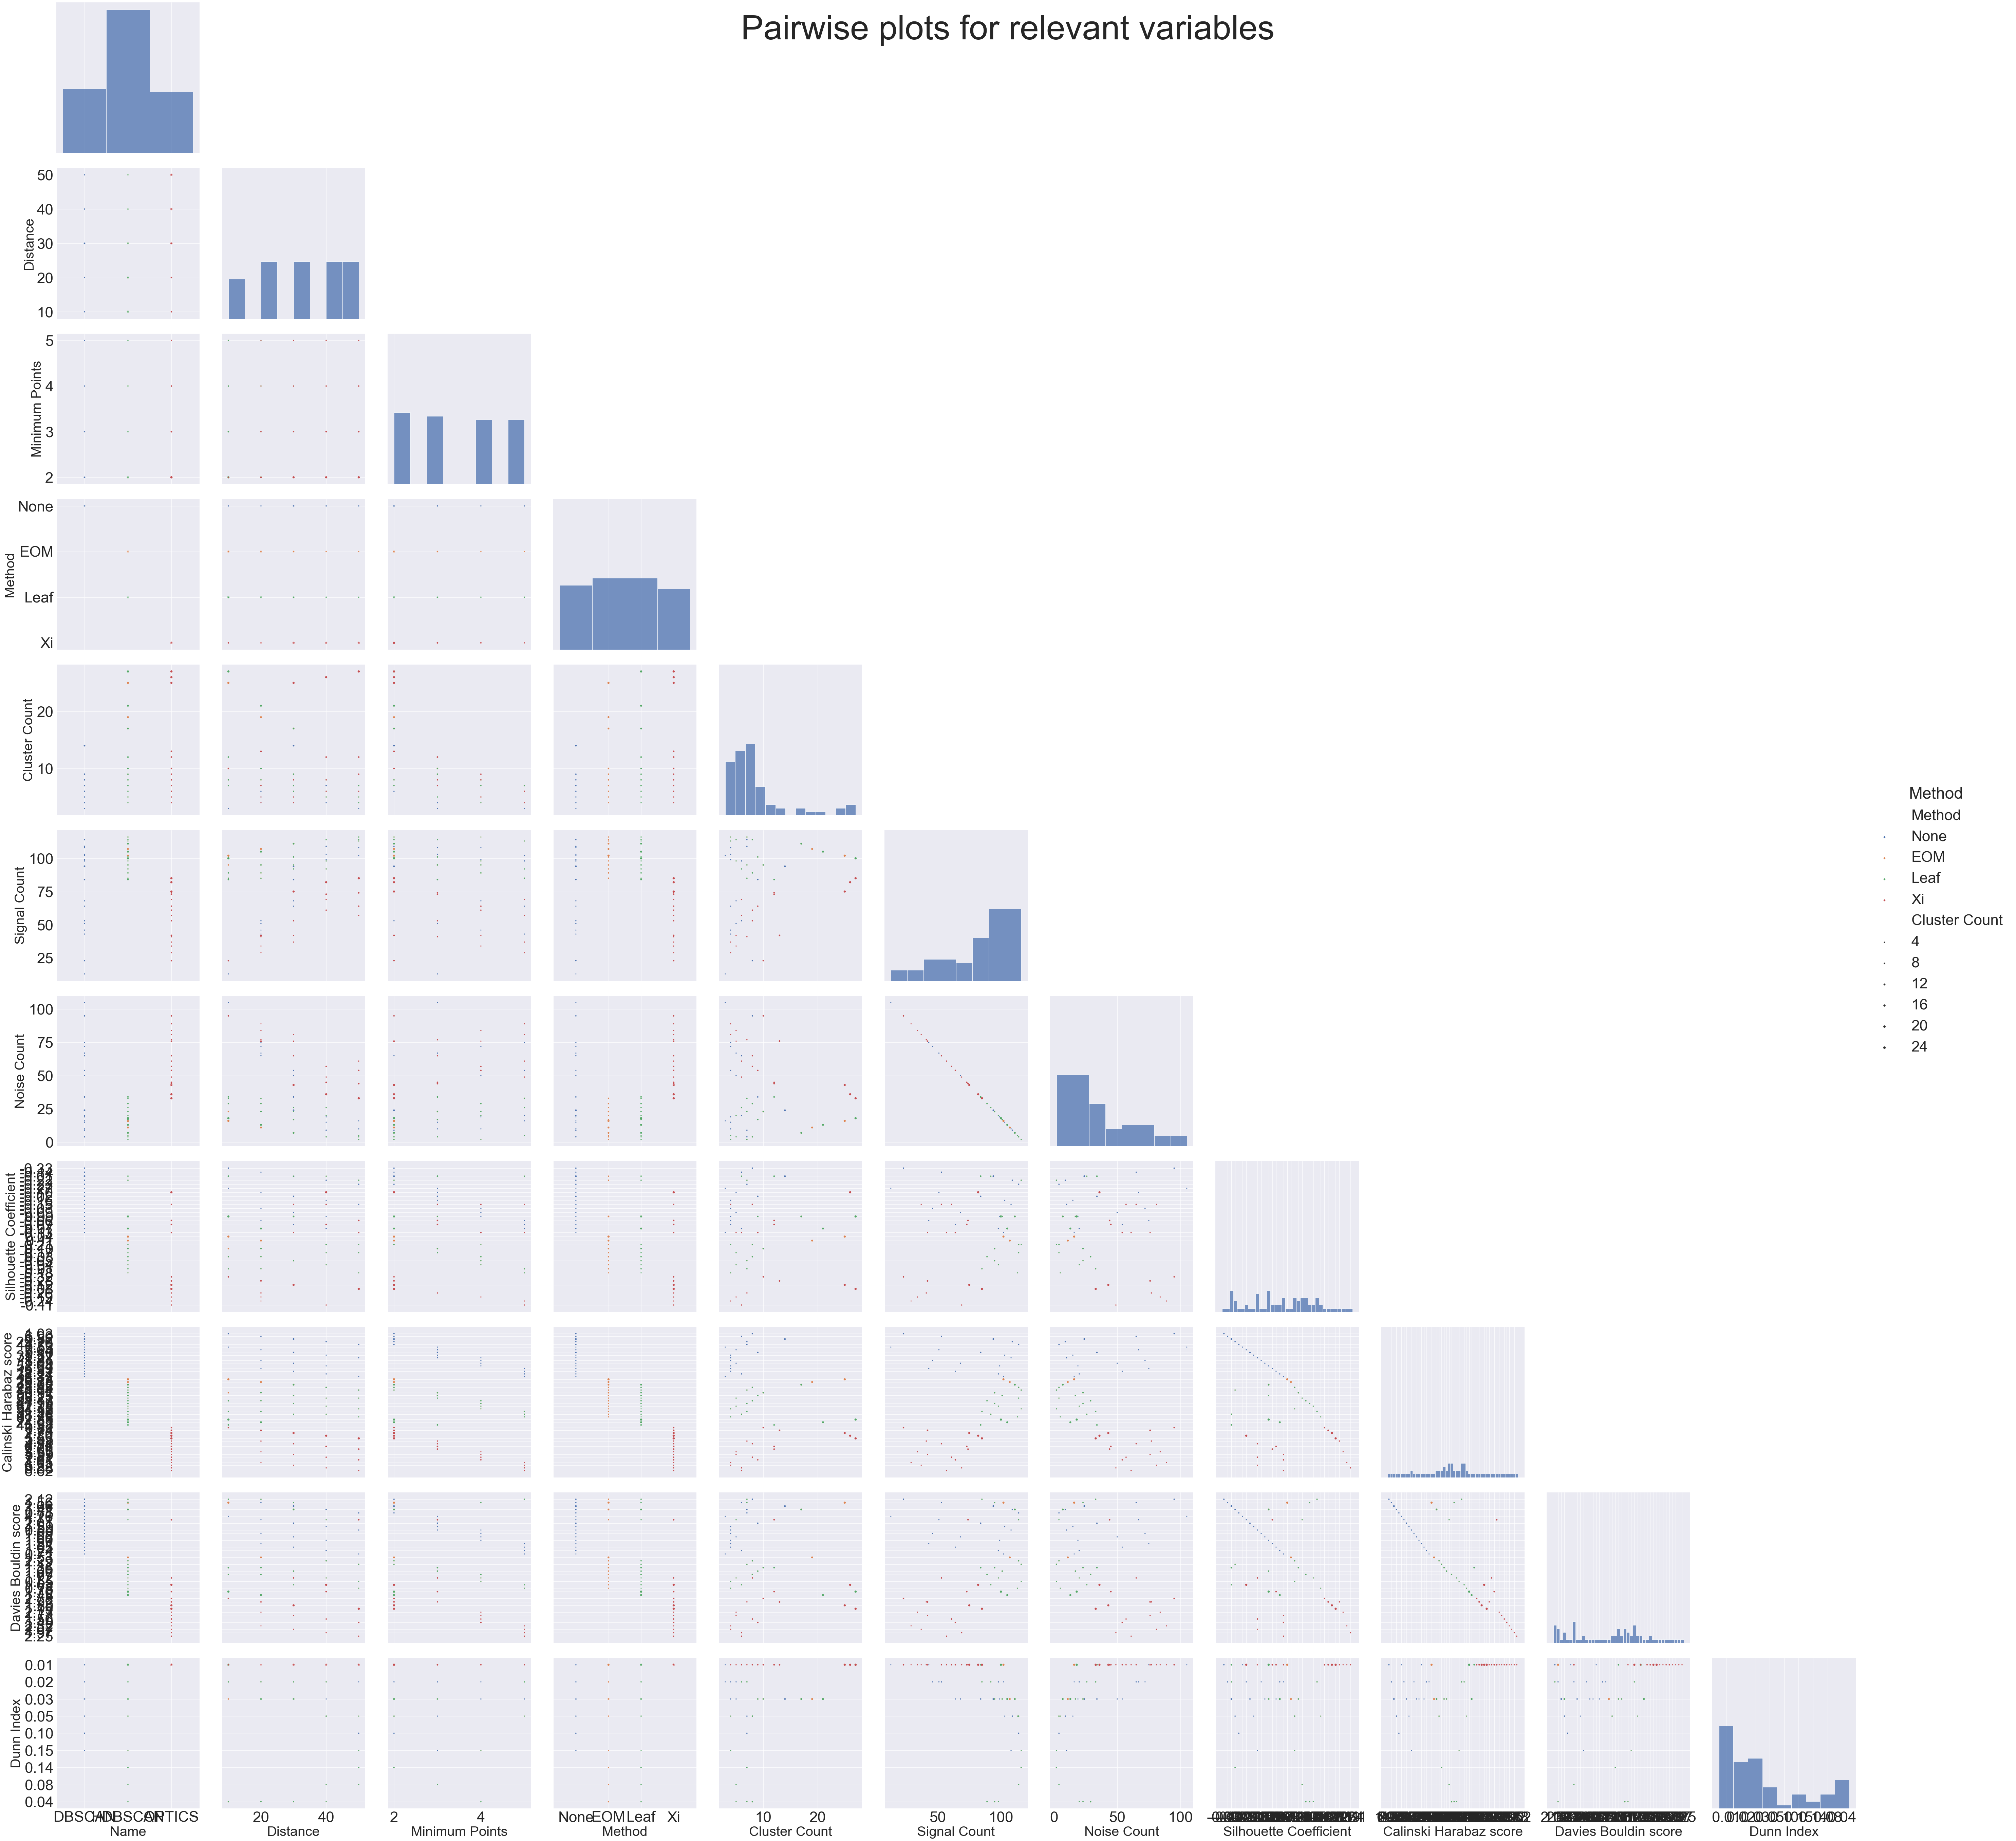

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pg_plot_df = cloud_clust_df.copy()
lst_vars = list(pg_plot_df.columns)
#lst_vars = list([''])
#x_vars=[cloud_clust_df['Distance'],cloud_clust_df['Minimum Points'],
#        cloud_clust_df['Cluster Count'],cloud_clust_df['Signal Count'],
#        cloud_clust_df['Noise Count']]
#y_vars=[cloud_clust_df['Silhouette Coefficient'],cloud_clust_df['Calinski Harabaz score'],
#        cloud_clust_df['Davies Bouldin score'],cloud_clust_df['Dunn Index']]
sns.color_palette("husl", 4)
sns.set_context("paper", rc={"font.size":8, "axes.labelsize":40}, font_scale=5)
''' kind = hist, scatter, '''
#g = sns.PairGrid(cloud_clust_df, hue='Method_Code', corner=True,hue_order=None,
#                 kind='scatter', diag_kind='hist', height=7,markers='o',
#                 plot_kws={"s": 200}, color=".3")
g = sns.PairGrid(pg_plot_df, hue="Method", vars=lst_vars, corner=True, height=7)
g.map_diag(sns.histplot, hue=None)
#g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot)
g.map_offdiag(sns.scatterplot,s=200, size=pg_plot_df["Cluster Count"])
g.fig.suptitle("Pairwise plots for relevant variables", size=100) # y= some height > 1
g.add_legend()
#g.fig.legend(markerscale=2)
plt.show()

In [ ]:
from scipy.stats import normaltest, ansari, chisquare, chi2, chi2_contingency
import numpy as np

_hypo_test_df = _norm_df.copy()

for p_mesr_idx, p_mesr_name in enumerate(lst_norm_cols):
    p_mesr_arr = _hypo_test_df[p_mesr_name].to_numpy()
    s_norm = ""
    s_chisqr = ""
    norm_stat, norm_p = normaltest(p_mesr_arr)
    chisqr_sta, chisqr_p = chisquare(p_mesr_arr)

    if norm_p < 0.05:
        s_norm = '[Normal distribution]'
    if chisqr_p < 0.05:
        s_chisqr = "[Chisquare]"
    print('%s Mean = %0.04f & Variance = %0.04f %s %s' 
          % (p_mesr_name, np.mean(p_mesr_arr), np.var(p_mesr_arr), s_norm, s_chisqr))
    
    for s_mesr_idx, s_mesr_name in enumerate(lst_norm_cols):
        if s_mesr_idx > p_mesr_idx:
            validity_data = np.array([_hypo_test_df[p_mesr_name],_hypo_test_df[s_mesr_name]])
#            chi_stat, chi_p, chi_dof, expected = chi2_contingency(validity_data,correction=False)
#            print(validity_data[0],validity_data[1])
            ans_stat, ans_p = ansari(validity_data[0],validity_data[1])
#            print('H0: %s is different from %s stat: %0.04f p-value: %0.04f dof: %0.04f' 
#                  % (p_mesr_name,s_mesr_name, stat, p, dof))
            if ans_p < 0.05:
                print('Different from %s with p-value: %0.04f' % (s_mesr_name, ans_p))
            else:
                print('Same as %s with p-value: %0.04f' % (s_mesr_name, ans_p))
    print()